<a href="https://colab.research.google.com/github/bundickm/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

## Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

X_train = train.drop('Fail',axis=1)
y_train = train['Fail']

X_test = test.drop('Fail',axis=1)
y_test = test['Fail']

In [0]:
#copy and paste code from an EDA library I'm flirting with building
from tabulate import tabulate

def null_rec_lookup(null_percent,placeholders=False):
  #replace with more detailed and rigorous recs
  if placeholders:
    return 'Possible Placeholders: Replace and rerun nulls report.'
  elif null_percent == 100:
    return 'Empty Column: Drop column'
  elif null_percent >= 75:
    return 'Near Empty Column: Create binary feature or drop'
  elif null_percent >= 25:
    return 'Partially Filled Column: Assess manually'
  elif null_percent > 0:
    return 'Mostly Filled Column: Impute values'
  else:
    return ''

def list_to_string(list):
  return ', '.join(str(item) for item in list)

def placeholders_present(column,placeholders):
  p_holds = []
  for item in placeholders:
    if len(column.isin([item]).unique())==2:
      p_holds.append(item)
  return list_to_string(list(set(p_holds)))
  
def nulls(df,placeholders = [-1,-999,-9999,'None','none','missing',
                                   'Missing','Null','null','?']):
  null_count = df.isnull().sum().loc
  total = len(df)
  
  headers = ['Column','Nulls','%Null','Placeholders','Recommendation']
  table = []
  for column in df.columns:
    calc = null_count[column]/total*100
    null_per = str(calc)+'%'
    p_hold = placeholders_present(df[column],placeholders)
    rec = null_rec_lookup(calc,p_hold)
    
    table.append([column,null_count[column],null_per,p_hold,rec])
    
  print(tabulate(table,headers))
  
def describe(df):
  headers = ['Column']+list(df.describe()[1:].T)
  table = df.describe()[1:].T.reset_index().to_numpy()
  print(tabulate(table,headers,))
  
def type_and_unique(df,unq_limit=10):
  cols = df.columns
  d_types = list(df.dtypes)
  num_unique = list(df.nunique())
  table = []
  headers=['Column','Type','nUnique','Unique Values']
  
  for i in range(len(df.columns)):
    unique_vals = list_to_string(list(df[cols[i]].unique()[:unq_limit]))
    if (len(list(df[cols[i]].unique())) > unq_limit): 
      unique_vals += '...'

    table.append([cols[i],str(d_types[i]),num_unique[i],unique_vals])
  print(tabulate(table,headers=headers))

def rundown(df):
  print('DataFrame Shape')
  print('Rows:',df.shape[0],'    Columns:',df.shape[1])
  print()
  nulls(df)
  print()
  describe(df)
  print()
  type_and_unique(df)

In [427]:
#one stop shop for basic info
rundown(train)

DataFrame Shape
Rows: 51916     Columns: 17

Column             Nulls  %Null                   Placeholders    Recommendation
---------------  -------  ----------------------  --------------  -----------------------------------
Inspection ID          0  0.0%
DBA Name               0  0.0%
AKA Name             623  1.2000154095076663%                     Mostly Filled Column: Impute values
License #              5  0.00963094229139379%                    Mostly Filled Column: Impute values
Facility Type        224  0.43146621465444174%                    Mostly Filled Column: Impute values
Risk                  12  0.023114261499345097%                   Mostly Filled Column: Impute values
Address                0  0.0%
City                  53  0.10208798828877418%                    Mostly Filled Column: Impute values
State                 10  0.01926188458278758%                    Mostly Filled Column: Impute values
Zip                   26  0.05008089991524771%                    M

In [428]:
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [429]:
#Naive model, since it is ROC_AUC it will always be .5
from sklearn.metrics import roc_auc_score

roc_auc_score(train['Fail'],([1]*51916))

0.5

## Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

In [0]:
# !pip install category_encoders

In [0]:
import numpy as np
import category_encoders as ce

In [0]:
def feature_engineer(df):
  df = df.copy()
  
  #drop factors that shouldn't have any bearing like name and Inspection ID
  #drop location data in favor of zip
  #drop Violations because we wouldn't know that pre-inspection so it's leakage
  df = df.drop(['DBA Name','AKA Name','Inspection ID','Address', 'License #',
           'City','State','Location','Violations'], axis=1)
  
  #convert to datetime
  df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])
  df['Day Of Week'] = df['Inspection Date'].dt.dayofweek
  df['Month'] = df['Inspection Date'].dt.month
  df['Year'] = df['Inspection Date'].dt.year
  df = df.drop('Inspection Date',axis=1)
  
  #encode risk, replace NaN with medium risk
  df['Risk'] = df['Risk'].replace({'Risk 1 (High)':2, 'Risk 3 (Low)':0, 
                                   'Risk 2 (Medium)':1, np.nan:1})
    
#   #reduce categories then encode
  def get_facility(group):
    if group in ['Daycare (2 - 6 Years)','School','Daycare Above and Under 2 Years','Daycare (Under 2 Years)']:
      return 'School/Daycare'
    elif group in ['Restaurant','Golden Diner','TAVERN','RESTAURANT','Mobile Food Dispenser']:
      return 'Restaurant'
    elif group in ['Grocery Store']:
      return 'Grocery'
    else:
      return 'Other'
  df['Facility Type'] = df['Facility Type'].apply(get_facility)

  
  #reduce categories then encode
  df['Inspection Type'] = df['Inspection Type'].replace({np.nan:'Other'})
  def get_inspection(group):
    if group in ['Canvass','Canvass Re-Inspection']:
      return ''
    elif group in ['License','License Re-Inspection']:
      return 'License'
    elif group in ['Complaint','Complaint Re-Inspection','Short Form Complaint']:
      return 'Complaint'
    elif group in ['Suspected Food Poisoning']:
      return 'Food Poisoning'
    else:
      return 'Other'
  df['Inspection Type'] = df['Inspection Type'].apply(get_inspection)
  
  encoder = ce.OrdinalEncoder()
  df = encoder.fit_transform(df)
  
  df = df.fillna(method='ffill')
  
  return df

## Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [0]:
X_train = feature_engineer(X_train)

In [434]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_distributions = {
    'n_estimators':[175],
    'max_depth':[8,9,10],
    'learning_rate':[.01]
}

search = RandomizedSearchCV(
    XGBClassifier(n_jobs=-1, random_state=42,),
    param_distributions=param_distributions, n_iter=3, cv=3,
    scoring='roc_auc', verbose=10,
    return_train_score=True, n_jobs=-1
)

search.fit(X_train, y_train)
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score').head(1)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.1min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.4min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,14.10793,0.154649,0.332892,0.025651,175,8,0.01,"{'n_estimators': 175, 'max_depth': 8, 'learnin...",0.620493,0.621526,0.61963,0.62055,0.000775,1,0.720966,0.716355,0.710888,0.71607,0.004119


In [435]:
#forgot to test against the test set, big stupid mistake
best = search.best_estimator_
X_test = feature_engineer(X_test)
y_pred = best.predict_proba(X_test)[:,1]

print('Test ROC AUC:', roc_auc_score(y_test, y_pred))

Test ROC AUC: 0.627601257255364


## Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

In [0]:
import matplotlib.pyplot as plt

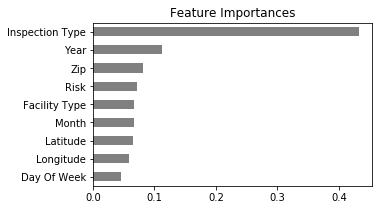

In [423]:
n = len(X_train.columns)
figsize = (5,n//3)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]

plt.figure(figsize=figsize)
top_n.plot.barh(color='gray')
plt.title('Feature Importances')
plt.show()

In [0]:
!pip install eli5

In [0]:
X_test = feature_engineer(X_test)

In [0]:
#table of feature importances via permutation importance
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_test.values, y_test)

feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0334 ± 0.0048,Year
0.0136 ± 0.0015,Latitude
0.0134 ± 0.0016,Longitude
0.0114 ± 0.0008,Zip
0.0074 ± 0.0034,Month
0.0061 ± 0.0006,Facility Type
0.0056 ± 0.0003,Risk
0.0022 ± 0.0013,Day Of Week
-0.0000 ± 0.0124,Inspection Type


## Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?

Gradient descent is an optimization algorithm used to minimize some error function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. In machine learning, we use gradient descent to update the parameters of our model.

1.   Define a Cost Function
2.   Evaluate slope (gradient) at current point
3.   Take small step (alpha or learning rate) in direction of slope descent
4.   Repeat steps 2 and 3 until slope approaches 0

- What is the "Learning Rate" and what is its function?

Learning rate (or alpha) is the step size taken once the direction of descent is determined. A large learning rate may train faster but has a chance of overshooting and diverging from the minimum. A small learning rate is unlikely to diverge but may take a while to converge on the minimum if the rate is too small.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._